In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adagrad, SGD, Adadelta, RMSprop
import matplotlib.pyplot as plt

In [2]:
folder_dir = 'dataset/flowers/'

In [5]:
#Now the next step is to read each image in the data and create a label for each with the name of the folder:
data = []
label = []

SIZE = 128

for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

In [9]:
# label
# data

In [10]:
data_arr = np.array(data)
label_arr = np.array(label)

In [13]:
# data_arr
# label_arr

In [14]:
data_arr.max()

255

In [25]:
# Now let’s use the Label encoder and normalize the data:
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y, 5)
X = data_arr/255

In [26]:
X.max()

1.0

In [27]:
#The next step is to split the dataset into 80% training and 20% test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [28]:
#Now let’s build a neural network model for the task of Flower Recognition:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='Same', activation = 'relu', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size=(3,3), padding='Same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size=(3,3), padding='Same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size=(3,3), padding='Same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation='softmax'))


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
__________

In [29]:
#Before compiling the model we need to create more training images to prevent overfitting:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [30]:
#Now let’s compile the neural network model:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.0001), metrics=['accuracy'])

In [34]:
# Now let's train the model
batch_size=32
epochs=5
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

Epoch 1/5
108/108 [==============================] - 460s 4s/step - loss: 1.3539 - acc: 0.4022 - val_loss: 1.2095 - val_acc: 0.4618
Epoch 2/5
108/108 [==============================] - 486s 4s/step - loss: 1.2911 - acc: 0.4448 - val_loss: 1.1420 - val_acc: 0.5255
Epoch 3/5
108/108 [==============================] - 498s 5s/step - loss: 1.2330 - acc: 0.4693 - val_loss: 1.1498 - val_acc: 0.5289
Epoch 4/5
108/108 [==============================] - 514s 5s/step - loss: 1.1821 - acc: 0.5149 - val_loss: 1.0488 - val_acc: 0.5938
Epoch 5/5
108/108 [==============================] - 437s 4s/step - loss: 1.1366 - acc: 0.5454 - val_loss: 1.1047 - val_acc: 0.5706


In [36]:
# history.evaluate()

KeyboardInterrupt: 

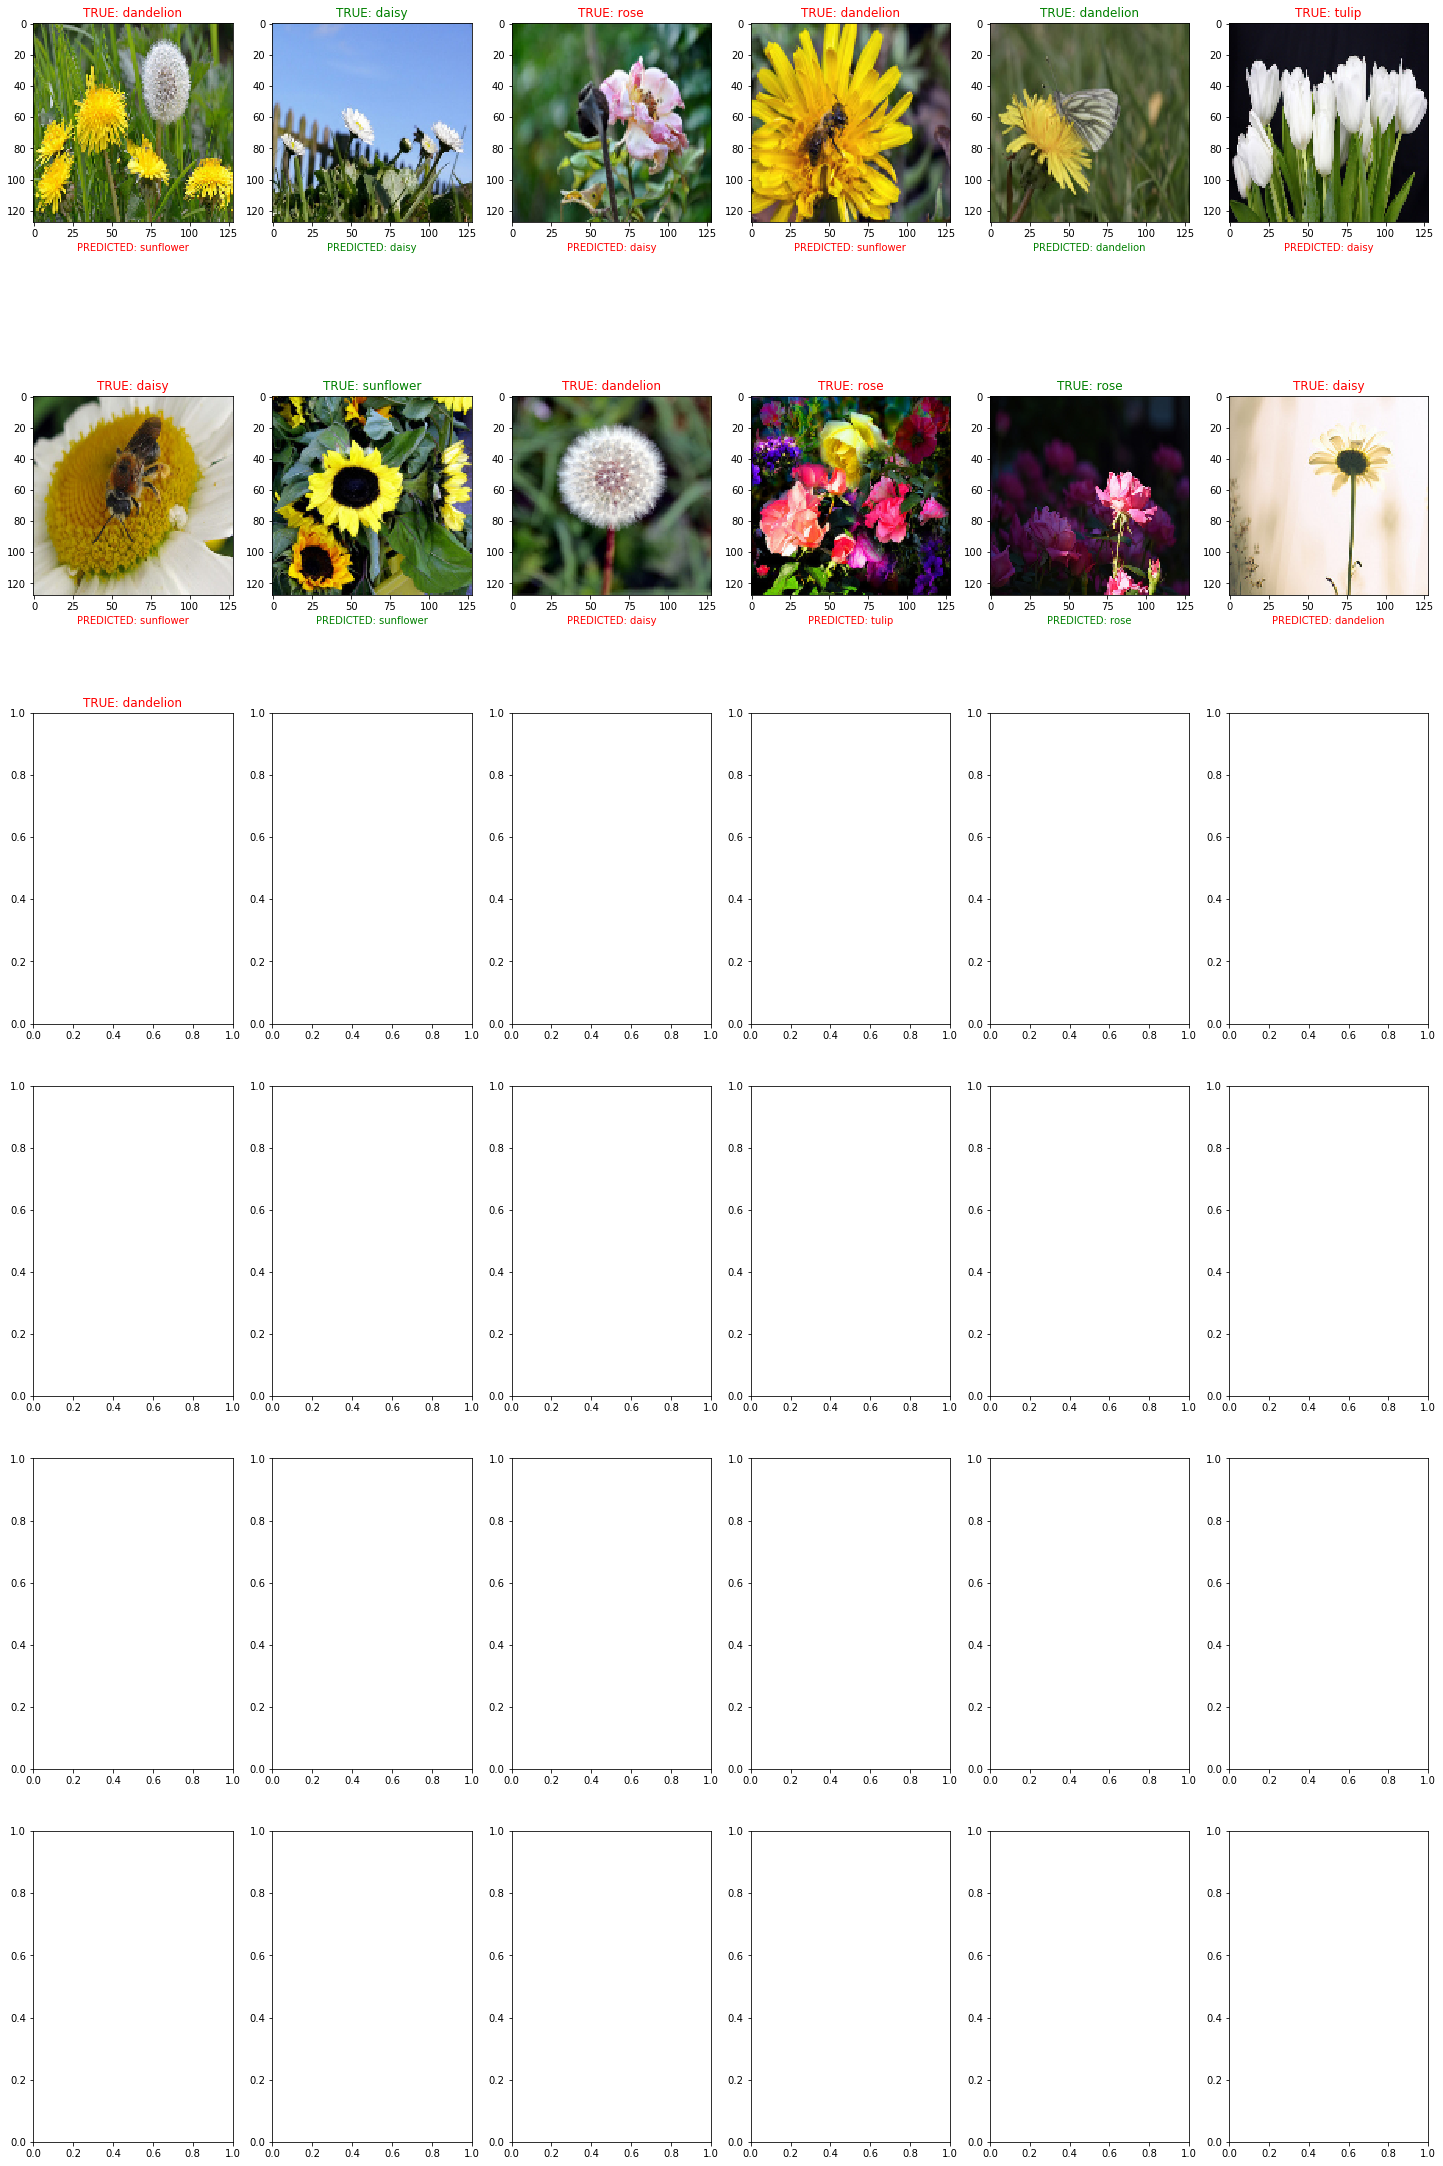

In [37]:
categories = np.sort(os.listdir(folder_dir))
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
        else:
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')